In [1]:

#LIBRARIES
import pandas as pd
import numpy as np
import quandl
from dotenv import load_dotenv
import os
import json
from pandas.io.json import json_normalize

#ML LIBRARIES
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key

# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date="2019-05-27"):
    return quandl.get(code, start_date=start_date, end_date=end_date)

# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng(df, n=10):
    
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df=df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    forecast_out = n # number of days of prediction
    
    #shifts label
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-forecast_out)
    df.dropna(inplace=True)
    return df
    
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

def LR_train(df):
    X = preprocessing.scale(df.drop('future_price10d', axis=1))
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test), reg

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Volatility,Change
Date,,,,,,,,,,,,,,
2013-09-03,105.13,105.8300,104.6600,105.01,3659800.0,0.0,1.0,91.075151,91.681568,90.667986,90.971194,3659800.0,0.011179,-0.001141
2013-09-04,105.05,107.1200,104.6200,106.37,3837500.0,0.0,1.0,91.005847,92.799108,90.633333,92.149376,3837500.0,0.023896,0.012565
2013-09-05,106.16,106.9770,105.6702,106.65,2590500.0,0.0,1.0,91.967450,92.675226,91.543132,92.391942,2590500.0,0.012367,0.004616
2013-09-06,107.00,107.3799,105.1100,106.07,3265200.0,0.0,1.0,92.695151,93.024262,91.057825,91.889483,3265200.0,0.021595,-0.008692
2013-09-09,106.58,107.3800,106.5550,107.19,2907600.0,0.0,1.0,92.331301,93.024348,92.309643,92.859750,2907600.0,0.007742,0.005723


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


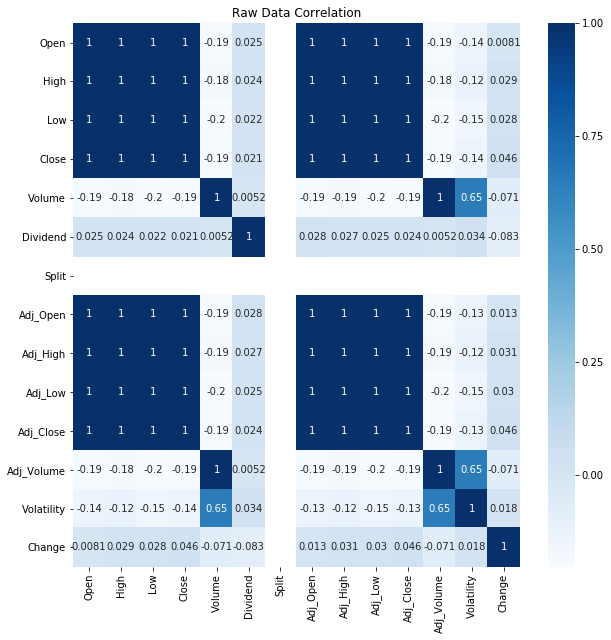

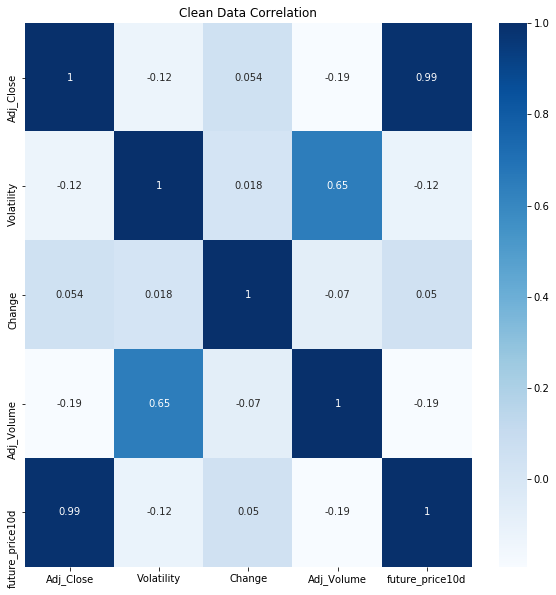

In [23]:
if __name__ == "__main__":

    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    #boeing = quandl_get()
    display(boeing.head())
    plot_corr(boeing, 10, 'Raw Data Correlation')
    boeing_clean = feature_eng(boeing)
    plot_corr(boeing_clean, 10,'Clean Data Correlation')
    score, reg =LR_train(boeing_clean)